In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts as ef


In [2]:
# INPUT CELL

summary = 'Derivative Fit with Old Settings. GP -> Blg + NFW. gamma = 1.'
gpu_id = '2'

mod_id = -1
svi_id = -131

# Important Fit Settings 
rig_temp_list = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_list = ['pib', 'ics', 'blg'] # pib, ics, blg
var_temp_list = ['nfw'] # nfw, dsk

is_gp = False
gp_deriv = False

data_file = 'canon_g1_pnfw' # fermi_data, sim
rig_temp_sim = ['iso', 'psc', 'bub']
hyb_temp_sim = ['pib', 'ics', 'blg']
var_temp_sim = ['nfw']
is_custom_blg = False
custom_blg_id = 0
sim_seed = 0 ; str_sim_seed = str(sim_seed)

Nu = 50
u_option = 'float' # 'float' or 'fixed'
u_grid_type = 'healpix_bins'
u_weights = 'data'

Np = 50
p_option = 'fixed' # 'float' or 'fixed'
Nsub = 1000

# Rest of parameters set to default values
ebin = 10
is_float64 = False
debug_nans = False
no_ps_mask = False
p_grid_type = 'healpix_bins'
p_weights = None
gp_kernel = 'ExpSquared'
gp_params = ['float', 'float']
gp_scale_option = 'Linear' # 'Linear' or 'Cholesky'
monotonicity_hyperparameter = 0.005
nfw_gamma = 1.

# fit specs, strings loaded for file saving

ebin = 10
str_ebin = str(ebin)

guide = 'iaf'
str_guide = guide

n_steps = 20000
str_n_steps = str(n_steps)

lr = 5e-4      
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 16
str_num_particles = str(num_particles)

svi_seed = 0
str_svi_seed = str(svi_seed)

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# directory where the data stored
data_dir = ef.load_data_dir(data_file)

# directory where fits stored
fit_filename, module_name = ef.generate_fit_filename(rig_temp_list, hyb_temp_list, var_temp_list, rig_temp_sim, hyb_temp_sim, var_temp_sim, is_gp, gp_deriv, is_custom_blg, custom_blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
os.system("mkdir -p "+fit_dir)

# command that converts numbers/strings to text strings
txt = lambda x: ('\'' + str(x) + '\'')

# save settings to module

with open(fit_dir + '__init__' +  '.py', 'w') as i:
    i.write('')

with open(fit_dir + module_name + '.py', 'w') as f:
    f.write('# Important Model Settings\n')
    f.write('rig_temp_list = ' + str(rig_temp_list) + '\n')
    f.write('hyb_temp_list = ' + str(hyb_temp_list) + '\n')
    f.write('var_temp_list = ' + str(var_temp_list) + '\n')
    f.write('is_gp = ' + str(is_gp) + '\n')
    f.write('gp_deriv = ' + str(gp_deriv) + '\n')
    f.write('data_file = ' + txt(data_file) + '\n')
    f.write('rig_temp_sim = ' + str(rig_temp_sim) + '\n')
    f.write('hyb_temp_sim = ' + str(hyb_temp_sim) + '\n')
    f.write('var_temp_sim = ' + str(var_temp_sim) + '\n')
    f.write('is_custom_blg = ' + str(is_custom_blg) + '\n')
    f.write('custom_blg_id = ' + str(custom_blg_id) + '\n')
    f.write('sim_seed = ' + str(sim_seed) + '; str_sim_seed = ' + txt(sim_seed) + '\n')
    f.write('Nu = ' + str(Nu) + '\n')
    f.write('u_option = ' + txt(u_option) + '\n')
    f.write('u_grid_type = ' + txt(u_grid_type) + '\n')
    f.write('u_weights = ' + txt(u_weights) + '\n')
    f.write('Np = ' + str(Np) + '\n')
    f.write('p_option = ' + txt(p_option) + '\n')
    f.write('Nsub = ' + str(Nsub) + '\n')
    f.write('\n')
    f.write('# Rest of model parameters set to default values\n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('is_float64 = ' + str(is_float64) + '\n')
    f.write('debug_nans = ' + str(debug_nans) + '\n')
    f.write('no_ps_mask = ' + str(no_ps_mask) + '\n')
    f.write('p_grid_type = ' + txt(p_grid_type) + '\n')
    f.write('p_weights = ' + str(p_weights) + '\n')
    f.write('gp_kernel = ' + txt(gp_kernel) + '\n')
    f.write('gp_params = ' + str(gp_params) + '\n')
    f.write('gp_scale_option = ' + txt(gp_scale_option) + '\n')
    f.write('monotonicity_hyperparameter = ' + str(monotonicity_hyperparameter) + '\n')
    f.write('nfw_gamma = ' + str(nfw_gamma) + '\n')

# add these additional parameters and the str_ versions to text file
with open(fit_dir + module_name + '.py', 'a') as f:
    f.write('\n')
    f.write('# SVI Parameters \n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('str_ebin = str(ebin)' + '\n')
    f.write('guide = ' + txt(guide) + '\n')
    f.write('str_guide = guide' + '\n')
    f.write('n_steps = ' + str(n_steps) + '\n')
    f.write('str_n_steps = str(n_steps)' + '\n')
    f.write('lr = ' + str(lr) + '\n')
    f.write('str_lr = ' + txt(lr) + '\n')
    f.write('num_particles = ' + str(num_particles) + '\n')
    f.write('str_num_particles = str(num_particles)' + '\n')
    f.write('svi_seed = ' + str_svi_seed + '\n')
    f.write('str_svi_seed = ' + txt(str_svi_seed))

# add summary to its own text file
with open(fit_dir + 'summary' + '.txt', 'w') as f:
    f.write(summary)

In [4]:
from models.poissonian_ed import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        )

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# configure model, run SVI, and generate samp 

ebinmodel.config_model(ebin=ebin)
svi_results = ebinmodel.fit_SVI(
    rng_key=jax.random.PRNGKey(svi_seed),
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin,
    num_flows=5, hidden_dims=[256, 256],
)
samples = ebinmodel.get_svi_samples(num_samples=50000)

100%|██████████| 20000/20000 [00:38<00:00, 518.65it/s, init loss: 13390370.0000, avg. loss [19001-20000]: 9804.6523] 


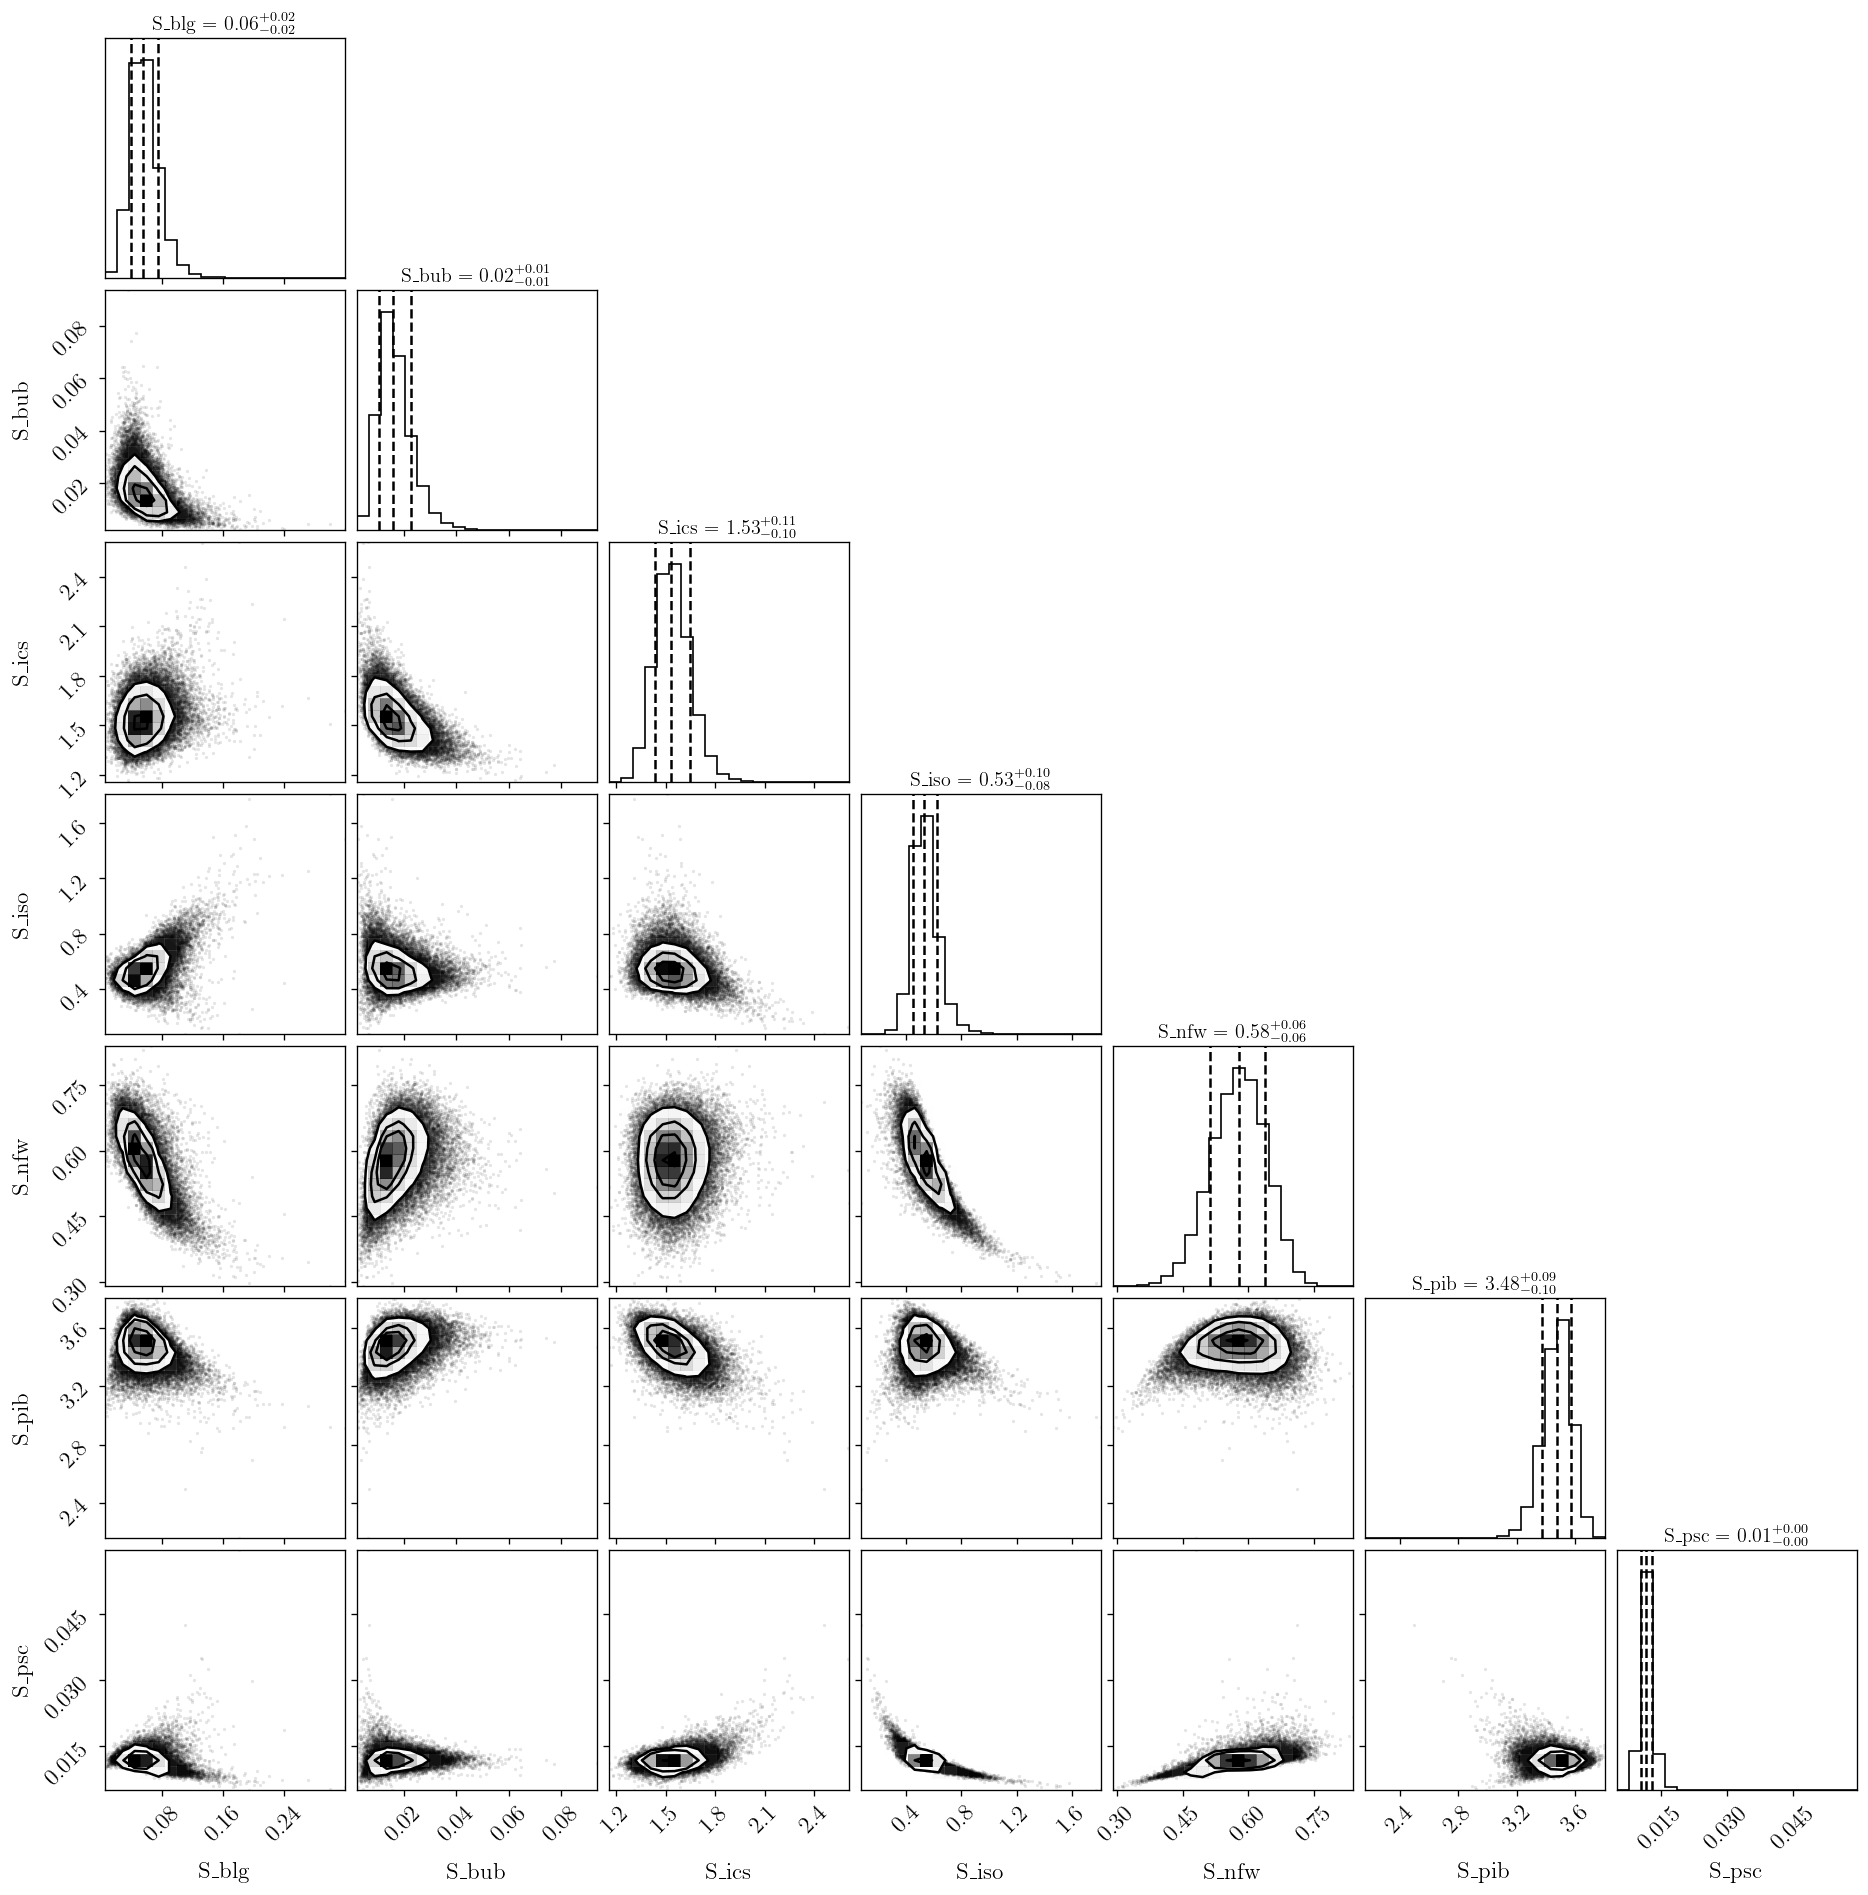

In [6]:
# generate corner plots of samples

fig = ef.make_corner_plots(samples, with_mean_vlines = False, with_log_rate_u = False)

(9000.0, 10000.0)

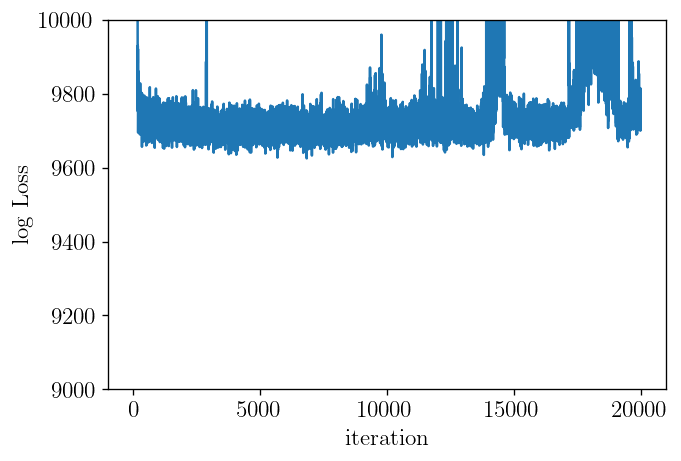

In [7]:
# loss vs step plot

plt.plot(svi_results.losses)
plt.xlabel('iteration')
plt.ylabel('log Loss')  
# plt.xlim(1000, n_steps)
plt.ylim(9000,10000)

In [16]:
from jax.scipy.special import expit
from utils import ed_fcts as ef

mask = ebinmodel.mask_roi_arr[10]
x_p = ef.get_x_from_mask(mask)
xu_f = ef.load_inducing_points(ebinmodel, svi_results)
mu = svi_results.params["auto_loc"]

ef.plot_inducing_points(xu_f, x_p, mu)

Not a GP model


KeyError: 'auto_loc'

In [ ]:
gp_samples = ebinmodel.get_gp_samples(num_samples=1000)

ValueError: GP is not enabled.

/data/edr76/gce-prob-prog-ed-v0.2/notebooks/../utils/ed_fcts.py:660: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.2/notebooks/../utils/ed_fcts.py:660: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.2/notebooks/../utils/ed_fcts.py:660: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


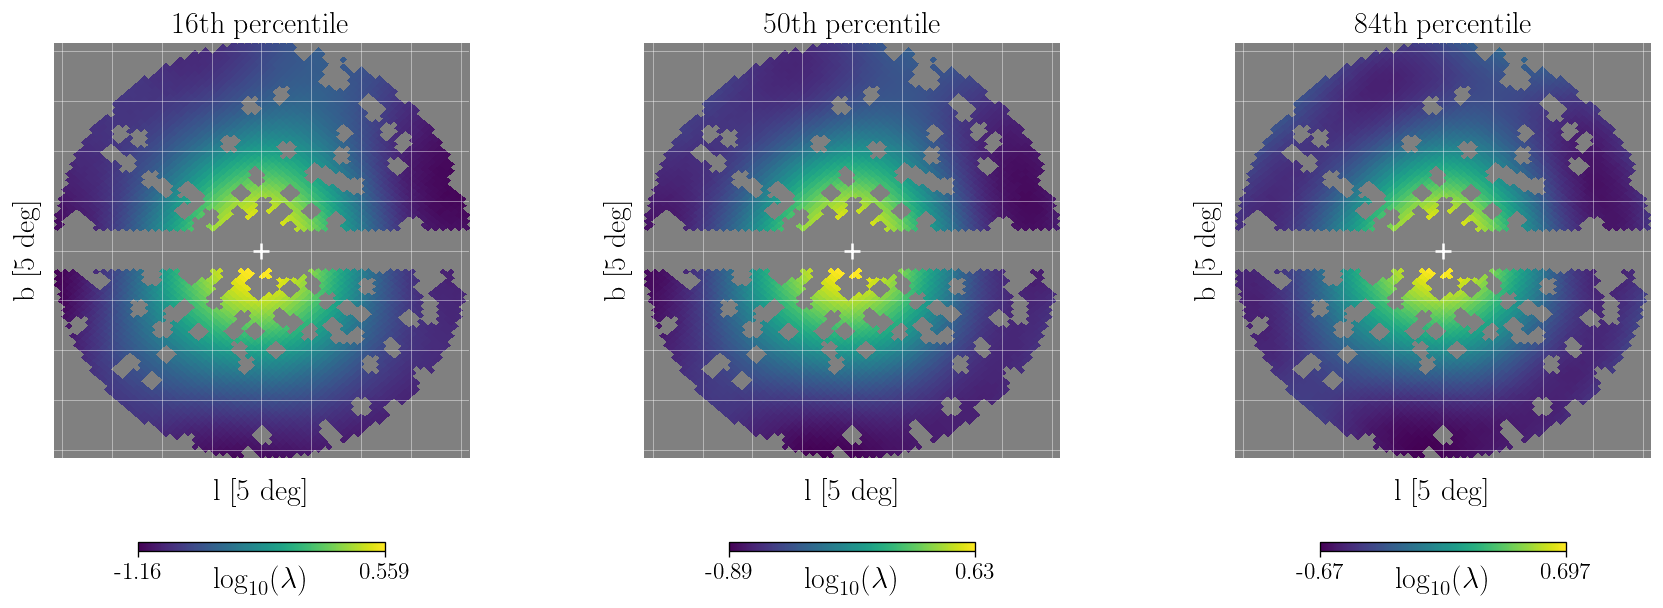

In [ ]:
nside = ebinmodel.nside

q = np.percentile(gp_samples, [16,50,84], axis = 0)

titles = ['16th percentile', '50th percentile', '84th percentile']

fig = plt.figure(figsize=(18, 6), dpi= 120)
for i in range(3):
    map_p = ef.convert_masked_array_to_hp_array(np.exp(q[i]), mask, log_option = True, nside = 128)

    ax = fig.add_subplot(1,3,i+1)
    plt.axes(ax)
    title = titles[i]
    ef.gnomview_plot(map_p,title)

In [8]:
# save svi results and samples to file

file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')
pickle.dump(
    (samples, svi_results), 
    open(fit_dir + file_name, 'wb'))

In [32]:
print(fit_dir + file_name)

/data/edr76/gce-prob-prog-ed-v0.2/data/synthetic_data/canon_g1/fits/fit_7p1234567_7p1234567_0_-1_-1_-131/seed_2_0/ebin10_smp_svi_5e-05_60000_iaf_16_2_0.p


In [ ]:
print(svi_results.params['scale'])

KeyError: 'scale'